

## Multiple Output Models using the Keras Functional API



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import utils

In [ ]:


# # URL of the white wine dataset
URI = './winequality-white.csv'

# # load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# # fill the `is_red` column with zeros.
white_df["is_red"] = 0

# # keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [ ]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])



8.8
9.1


In [ ]:


# URL of the red wine dataset
URI = './winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [ ]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])



9.4
10.2


In [ ]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])



9.4
9.5


In [ ]:
df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

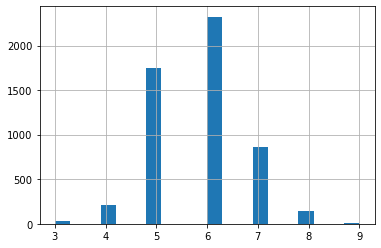

In [ ]:
df['quality'].hist(bins=20);

In [ ]:

# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8)]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])



9.4
10.9


You can plot again to see the new range of data and quality

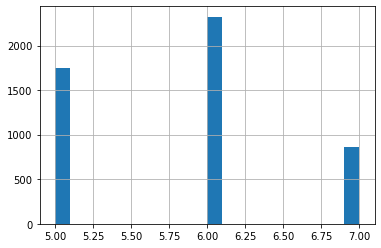

In [ ]:
df['quality'].hist(bins=20);

In [ ]:

# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [ ]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:


# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


### Normalize 
$$x_{norm} = \frac{x - \mu}{\sigma}$$


In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:

# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

In [ ]:


def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation='relu', name='base_dense_1')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation='relu', name='base_dense_2')(x)
    return x
  

In [ ]:

def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model

In [ ]:

inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mean_squared_error'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

In [ ]:

history = model.fit(norm_train_X, train_Y,
                    epochs = 40, validation_data=(norm_val_X, val_Y))

Train on 3155 samples, validate on 789 samples
Epoch 1/40
3155/3155 [==============================] - 1s 419us/sample - loss: 26.7004 - wine_quality_loss: 25.9323 - wine_type_loss: 0.7453 - wine_quality_root_mean_squared_error: 5.0946 - wine_type_accuracy: 0.3911 - val_loss: 19.1116 - val_wine_quality_loss: 18.4061 - val_wine_type_loss: 0.7079 - val_wine_quality_root_mean_squared_error: 4.2899 - val_wine_type_accuracy: 0.4816
Epoch 2/40
3155/3155 [==============================] - 0s 128us/sample - loss: 13.0178 - wine_quality_loss: 12.3255 - wine_type_loss: 0.6696 - wine_quality_root_mean_squared_error: 3.5140 - wine_type_accuracy: 0.5667 - val_loss: 7.5593 - val_wine_quality_loss: 6.9558 - val_wine_type_loss: 0.6222 - val_wine_quality_root_mean_squared_error: 2.6337 - val_wine_type_accuracy: 0.7098
Epoch 3/40
3155/3155 [==============================] - 0s 127us/sample - loss: 4.6399 - wine_quality_loss: 4.0639 - wine_type_loss: 0.5667 - wine_quality_root_mean_squared_error: 2.0182 

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')



789/789 [==============================] - 0s 27us/sample - loss: 0.3936 - wine_quality_loss: 0.3608 - wine_type_loss: 0.0316 - wine_quality_root_mean_squared_error: 0.6014 - wine_type_accuracy: 0.9949

loss: 0.3936284417133065
wine_quality_loss: 0.36082684993743896
wine_type_loss: 0.03158601373434067
wine_quality_rmse: 0.6013866662979126
wine_type_accuracy: 0.9949302673339844


In [ ]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [ ]:
print(quality_pred[0])



[5.465995]


In [ ]:
print(type_pred[0])
print(type_pred[944])




[0.00727621]
[0.9996642]


In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

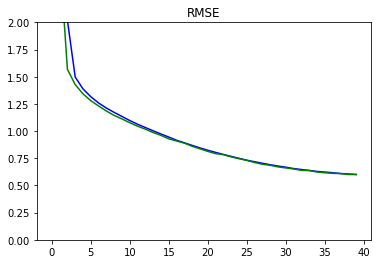

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

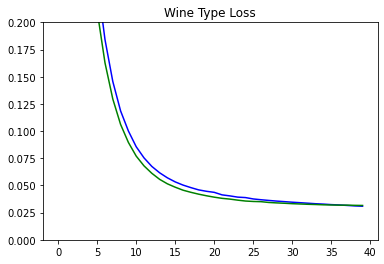

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix



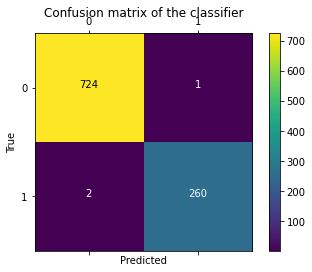

In [ ]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

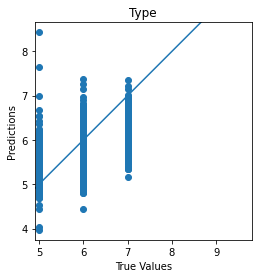

In [ ]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')